Import

In [1]:
import pandas as pd
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

plt.style.use('ggplot')

mpl.rcParams['axes.unicode_minus'] = False

File load

In [2]:
train = pd.read_csv("./bike-sharing-demand/train.csv", parse_dates=["datetime"])
test = pd.read_csv("./bike-sharing-demand/test.csv", parse_dates=["datetime"])

train.shape, test.shape

((10886, 12), (6493, 9))

In [3]:
train["year"] = train["datetime"].dt.year
train["month"] = train["datetime"].dt.month
train["hour"] = train["datetime"].dt.hour
train["dayofweek"] = train["datetime"].dt.dayofweek
train.shape

(10886, 16)

In [4]:
test["year"] = test["datetime"].dt.year
test["month"] = test["datetime"].dt.month
test["hour"] = test["datetime"].dt.hour
test["dayofweek"] = test["datetime"].dt.dayofweek
test.shape

(6493, 13)

Data Check

[Text(0, 0.5, 'count'), Text(0.5, 1.0, 'Rental amount by hour')]

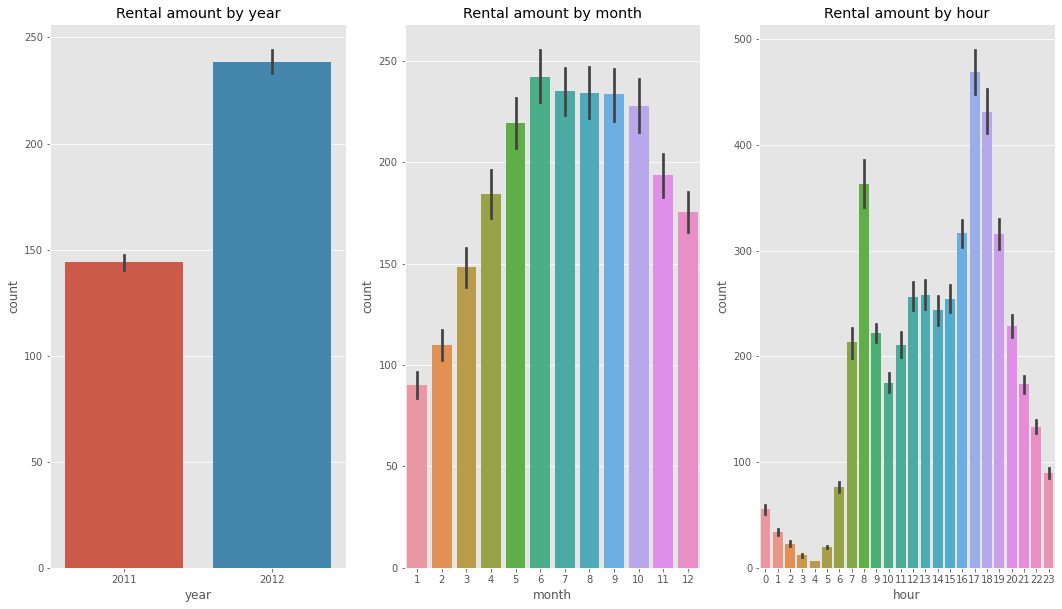

In [5]:
figure, (ax1,ax2,ax3) = plt.subplots(nrows = 1, ncols = 3)
figure.set_size_inches(18,10)

sns.barplot(data=train, x = "year", y = "count", ax = ax1)
sns.barplot(data=train, x = "month", y = "count", ax = ax2)
sns.barplot(data=train, x = "hour", y = "count", ax = ax3)

ax1.set(ylabel = "count", title = "Rental amount by year")
ax2.set(ylabel = "count", title = "Rental amount by month")
ax3.set(ylabel = "count", title = "Rental amount by hour")

In [8]:
pip install -U pandas-profiling

Note: you may need to restart the kernel to use updated packages.


In [9]:
from pandas_profiling import ProfileReport
profile = ProfileReport(train, title="Pandas Profiling Report")
profile

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [10]:
# Export html report
profile.to_file("train_profiling_report.html")

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

Data Preprocessing

In [42]:
# Category
# 범주형 feature의 type을 category로 변경
categorical_feature_names = ["season", "holiday", "workingday", "weather", "windspeed",
                             "dayofweek", "month", "year", "hour"]

In [7]:
for var in categorical_feature_names:
    train[var] = train[var].astype("category")
    test[var] = test[var].astype("category")

In [44]:
feature_names = ["season", "weather", "temp", "atemp", "humidity", "windspeed",
                 "year", "hour", "dayofweek", "holiday", "workingday"]
feature_names

['season',
 'weather',
 'temp',
 'atemp',
 'humidity',
 'windspeed',
 'year',
 'hour',
 'dayofweek',
 'holiday',
 'workingday']

In [45]:
X_train = train[feature_names]

print(X_train.shape)
X_train.head()

(10886, 11)


season weather  temp   atemp  humidity  windspeed  year hour dayofweek  \
0      1       1  9.84  14.395        81        0.0  2011    0         5   
1      1       1  9.02  13.635        80        0.0  2011    1         5   
2      1       1  9.02  13.635        80        0.0  2011    2         5   
3      1       1  9.84  14.395        75        0.0  2011    3         5   
4      1       1  9.84  14.395        75        0.0  2011    4         5   

  holiday workingday  
0       0          0  
1       0          0  
2       0          0  
3       0          0  
4       0          0

In [46]:
X_test = test[feature_names]

print(X_test.shape)
X_test.head()

(6493, 11)


season weather   temp   atemp  humidity  windspeed  year hour dayofweek  \
0      1       1  10.66  11.365        56    26.0027  2011    0         3   
1      1       1  10.66  13.635        56     0.0000  2011    1         3   
2      1       1  10.66  13.635        56     0.0000  2011    2         3   
3      1       1  10.66  12.880        56    11.0014  2011    3         3   
4      1       1  10.66  12.880        56    11.0014  2011    4         3   

  holiday workingday  
0       0          1  
1       0          1  
2       0          1  
3       0          1  
4       0          1

In [47]:
label_name = "count"

y_train = train[label_name]

print(y_train.shape)
y_train.head()

(10886,)


0    16
1    40
2    32
3    13
4     1
Name: count, dtype: int64

In [27]:
# existing 성능 평가 방법
from sklearn.metrics import make_scorer

def rmsle(predicted_values, actual_values, convertExp=True):
    
    if convertExp:
        predicted_values = np.exp(predicted_values),
        actual_values = np.exp(actual_values)
        
    predicted_values = np.array(predicted_values)
    actual_values = np.array(actual_values)
    
    log_predict = np.log(predicted_values+1)
    log_actual = np.log(actual_values+1)
    
    difference = log_predict - log_actual
    difference = np.square(difference)
    
    mean_difference = difference.mean()
    
    score = np.sqrt(mean_difference)
    
    return score

In [18]:
# import
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
import warnings
pd.options.mode.chained_assignment = None
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [19]:
#LinearRegression

lModel = LinearRegression()

y_train_log = np.log1p(y_train)
lModel.fit(X_train, y_train_log)

preds = lModel.predict(X_train)
print("RMSLE Value For Linear Regression : ", rmsle(np.exp(y_train_log), np.exp(preds), False))

RMSLE Value For Linear Regression :  0.9803697923313506


In [20]:
#Ridge Model
ridge_m_ = Ridge()
ridge_params_ = {'max_iter':[3000], 'alpha':[0.01, 0.1, 1, 2, 3, 4, 5, 10, 50, 100, 200, 300, 400, 500, 1000]}
rmsle_scorer = metrics.make_scorer(rmsle, greater_is_better=False)
grid_ridge_m = GridSearchCV(ridge_m_, ridge_params_, scoring = rmsle_scorer, cv=5)

y_train_log = np.log1p(y_train)

grid_ridge_m.fit(X_train, y_train_log)

preds = grid_ridge_m.predict(X_train)

print(grid_ridge_m.best_params_)
print("RMSLE Value For Ridge Regression : ", rmsle(np.exp(y_train_log), np.exp(preds), False))

{'alpha': 0.01, 'max_iter': 3000}
RMSLE Value For Ridge Regression :  0.9803697902780832


In [21]:
#Lasso
lasso_m_ = Lasso()

alpha = 1/np.array([0.01, 0.1, 1, 2, 3, 4, 5, 10, 50, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000])
lasso_params_ = {'max_iter' : [3000], 'alpha':alpha}

grid_lasso_m = GridSearchCV(lasso_m_, lasso_params_, scoring=rmsle_scorer, cv=5)

y_train_log = np.log1p(y_train)
grid_lasso_m.fit(X_train, y_train_log)

preds = grid_lasso_m.predict(X_train)

print(grid_lasso_m.best_params_)
print("RMSLE Value For Lasso Regression : ", rmsle(np.exp(y_train_log), np.exp(preds), False))

{'alpha': 0.0016666666666666668, 'max_iter': 3000}
RMSLE Value For Lasso Regression :  0.9803709413807513


In [15]:
#RandomForest
from sklearn.ensemble import RandomForestRegressor
rfModel = RandomForestRegressor(n_estimators=100)

y_train_log = np.log1p(y_train)
rfModel.fit(X_train, y_train_log)

preds = rfModel.predict(X_train)

score = rmsle(np.exp(y_train_log), np.exp(preds), False)
print("RMSLE Value For RandomForest Regression : ", score)

RMSLE Value For RandomForest Regression :  0.10717457656328067


In [49]:
#GridentBoosting
from sklearn.ensemble import GradientBoostingRegressor
gbm = GradientBoostingRegressor(n_estimators=1510, alpha=0.01);

y_train_log = np.log1p(y_train)
gbm.fit(X_train, y_train_log)

preds = gbm.predict(X_train)

score = rmsle(np.exp(y_train_log), np.exp(preds), False)
print("RMSLE Value For GradientBoostingRegressor Regression : ", score)

RMSLE Value For GradientBoostingRegressor Regression :  0.2305234673223433


In [17]:
#HistGridentBoosting
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingRegressor

hgbm = HistGradientBoostingRegressor();

y_train_log = np.log1p(y_train)
hgbm.fit(X_train, y_train_log)

preds = hgbm.predict(X_train)

score = rmsle(np.exp(y_train_log), np.exp(preds), False)
print("RMSLE Value For HistGradientBoostingRegressorr Regression : ", score)

RMSLE Value For HistGradientBoostingRegressorr Regression :  0.24470307614234507


In [34]:
#AdaBoost
from sklearn.ensemble import AdaBoost

ada = AdaBoost();

y_train_log = np.log1p(y_train)
ada.fit(X_train, y_train_log)

preds = ada.predict(X_train)

score = rmsle(np.exp(y_train_log), np.exp(preds), False)
print("RMSLE Value For AdaBoost Regression : ", score)

ImportError: cannot import name 'AdaBoost' from 'sklearn.ensemble' (C:\Anaconda3\lib\site-packages\sklearn\ensemble\__init__.py)

C:\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

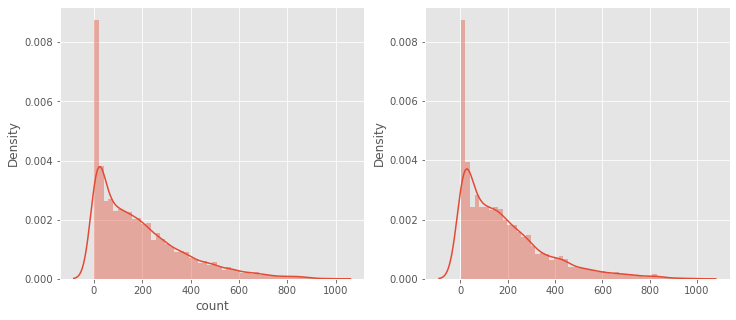

In [50]:
predsTest = gbm.predict(X_test)
fig, (ax1, ax2) = plt.subplots(ncols=2)
fig.set_size_inches(12, 5)

sns.distplot(y_train, ax=ax1, bins=50)
sns.distplot(np.exp(predsTest), ax=ax2, bins=50)

In [39]:
#GridentBoosting_Poly 적용
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures

gbm = GradientBoostingRegressor(n_estimators=4000, alpha=0.01)



# 특성 스케일 적용
# ss=StandardScaler()
# ss.fit(X_train_poly)
# X_train_scaled = ss.transform(X_train_poly)
# X_test_scaled = ss.transform(X_test_poly)
# print(X_train_poly.shape,X_test_poly.shape)

X_train_ohe = pd.get_dummies(X_train,columns=['year', 'hour','holiday','workingday','season','weather','dayofweek'])
X_test_ohe = pd.get_dummies(X_test,columns=['year','hour','holiday','workingday','season','weather','dayofweek'])

# 사이킷런 변환기 적용
poly = PolynomialFeatures()
poly.fit(X_train_ohe)
X_train_poly = poly.transform(X_train_ohe)
X_test_poly = poly.transform(X_test_ohe)

y_train_log = np.log1p(y_train)
gbm.fit(X_train_poly, y_train_log)

preds = gbm.predict(X_train_poly)

score = rmsle(np.exp(y_train_log), np.exp(preds), False)
print("RMSLE Value For GradientBoostingRegressor Regression : ", score)

RMSLE Value For GradientBoostingRegressor Regression :  0.11451123587768797


In [51]:
predsTest = gbm.predict(X_test_poly)
fig, (ax1, ax2) = plt.subplots(ncols=2)
fig.set_size_inches(12, 5)

sns.distplot(y_train, ax=ax1, bins=50)
sns.distplot(np.exp(predsTest), ax=ax2, bins=50)

NameError: name 'X_test_poly' is not defined

In [54]:
submission = pd.read_csv("./bike-sharing-demand/sampleSubmission.csv")
submission
          
submission["count"] = np.exp(predsTest)

print(submission.shape)
submission.head()

(6493, 2)


datetime      count
0  2011-01-20 00:00:00  11.618848
1  2011-01-20 01:00:00   5.956520
2  2011-01-20 02:00:00   3.823244
3  2011-01-20 03:00:00   2.510013
4  2011-01-20 04:00:00   2.372655

In [55]:
#미국 현충일
submission.iloc[1258:1269, 1]= submission.iloc[1258:1269, 1]*0.5
submission.iloc[4492:4515, 1]= submission.iloc[4492:4515, 1]*0.5
#크리스마스 이브
submission.iloc[6308:6330, 1]= submission.iloc[6308:6330, 1]*0.5
submission.iloc[3041:3063, 1]= submission.iloc[3041:3063, 1]*0.5
#크리스마스
submission.iloc[6332:6354, 1]= submission.iloc[6332:6354, 1]*0.5
submission.iloc[3065:3087, 1]= submission.iloc[3065:3087, 1]*0.5
#추수감사절
submission.iloc[5992:6015, 1]= submission.iloc[5992:6015, 1]*0.5
submission.iloc[2771:2794, 1]= submission.iloc[2771:2794, 1]*0.5

In [56]:
submission.to_csv("./bike-sharing-demand/Score_{0:.5f}_submission.csv".format(score), index=False)

In [23]:
# 교차검증

from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

k_fold = KFold(n_splits=10, shuffle=True, random_state=0)

In [24]:
from sklearn.ensemble import RandomForestRegressor

max_depth_list = []

model = RandomForestRegressor(n_estimators=100,
                              n_jobs=-1,
                              random_state=0)
model

RandomForestRegressor(n_jobs=-1, random_state=0)

In [33]:
%time score = cross_val_score(model, X_train, y_train, cv=k_fold, scoring=rmsle)
print("Score= {0:.5f}".format(score))

C:\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 90, in __call__
    score = scorer(estimator, *args, **kwargs)
  File "C:\Users\JAEKYUN\AppData\Local\Temp/ipykernel_16048/4201896651.py", line 6, in rmsle
    if convertExp:
  File "C:\Anaconda3\lib\site-packages\pandas\core\generic.py", line 1537, in __nonzero__
    raise ValueError(
ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

  warnings.warn(
C:\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partit

Wall time: 4.67 s


C:\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 90, in __call__
    score = scorer(estimator, *args, **kwargs)
  File "C:\Users\JAEKYUN\AppData\Local\Temp/ipykernel_16048/4201896651.py", line 6, in rmsle
    if convertExp:
  File "C:\Anaconda3\lib\site-packages\pandas\core\generic.py", line 1537, in __nonzero__
    raise ValueError(
ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

  warnings.warn(


TypeError: unsupported format string passed to numpy.ndarray.__format__